In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

/opt/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
good_maps = [
    'data/13_102.5_104.5_0.1.npy',
    'data/15_216_220_0.2.npy',
    'data/15_314.5_318.5_0.2.npy',
    'data/13_370_400_0.5.npy',
    'data/13_490_496_0.2.npy',
    'data/15_646_650_0.2.npy',
    'data/15_710_718_0.2.npy',
    'data/15_900_905_0.2.npy',
    'data/15_1138_1158_0.3.npy'
]
eigenmodes = [
    [1, 1], #102
    [[1, 2], [2, 1]], #216
    [2, 2], #314
    [[1, 3], [3, 1]], #370
    [[2, 3], [3, 2]], #490
    [3, 3], #646
    [[2, 4], [4, 2]],#710 
    [[1, 5], [5, 1]],#900
    [[3, 5], [5, 3]]#1138
]

Here are all the eigenmode functions:

In [3]:
eigenmode_function = []
eigenmode_function.append(lambda x: 0.75*(np.cos(x)+.333*np.cos(3*x)))
eigenmode_function.append(lambda x: 0.667*(np.sin(2*x)+.5*np.sin(4*x)))
eigenmode_function.append(lambda x: 0.625*(np.cos(3*x)+.6*np.cos(5*x)))
eigenmode_function.append(lambda x: 0.6*(np.sin(4*x)+0.667*np.sin(6*x)))
eigenmode_function.append(lambda x: 0.583*(np.cos(5*x)+.71429*np.cos(7*x)))

Let's generate a data domain for this:

In [4]:
ADC_to_voltage = 1./95.6
vmax = 3.2*ADC_to_voltage
mm_per_gridpoint = 16.485
steps_to_edge = 7950. #\pm 50
steps_taken_max = 5000. #(some data has 5000)
phase_at_edge = 1.0
phase_at_max = phase_at_edge*steps_taken_max/steps_to_edge
x_domain_full = np.linspace(-phase_at_edge, phase_at_edge, 1000)
y_domain_full = np.copy(x_domain_full)

Now, let's generate the appropriate amplitudes:

In [5]:
eigenmode_amplitudes = np.array(
    [[np.dot(eigenmode_function[i](x_domain_full)[:, None],
       eigenmode_function[j](y_domain_full)[None])
       for i in range(5)] for j in range(5)])

Let's plot one of these, say the 1-1 mode, as a sanity check:

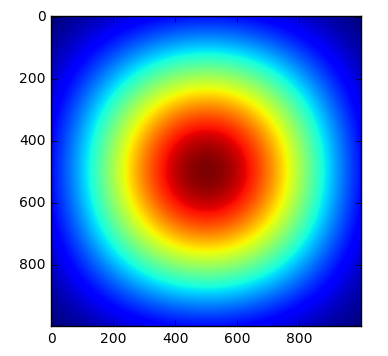

In [6]:
plt.imshow(np.dot(eigenmode_function[0](x_domain_full)[:, None],
                   eigenmode_function[0](y_domain_full)[None]))

Now let's plot all of our theory data:

[1, 1]


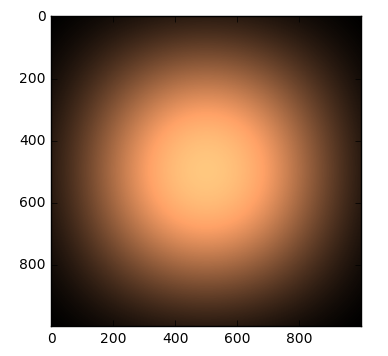

[[1, 2], [2, 1]]


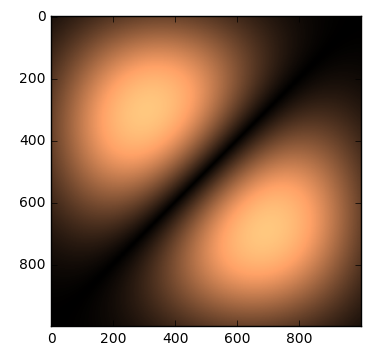

[2, 2]


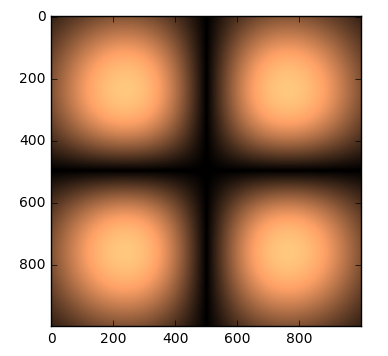

[[1, 3], [3, 1]]


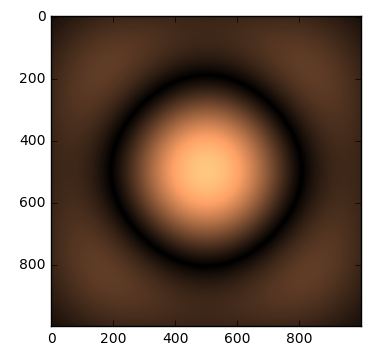

[[2, 3], [3, 2]]


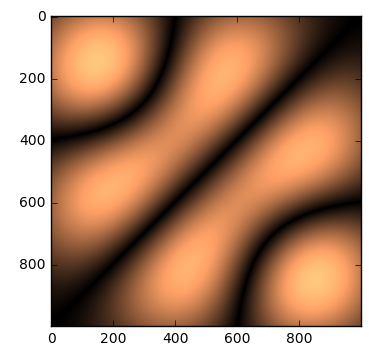

[3, 3]


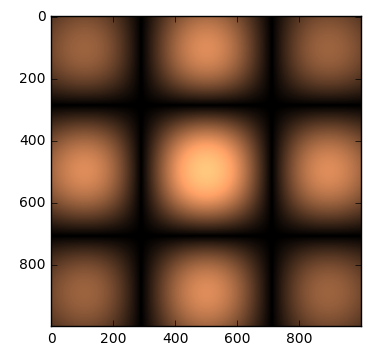

[[2, 4], [4, 2]]


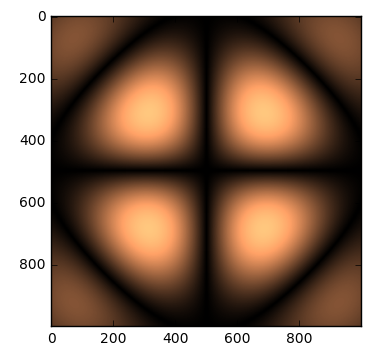

[[1, 5], [5, 1]]


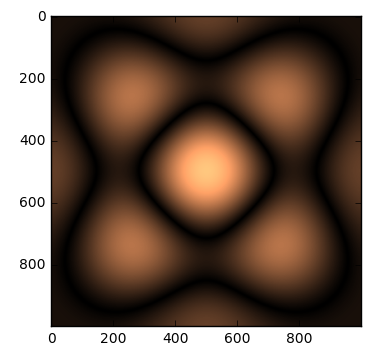

[[3, 5], [5, 3]]


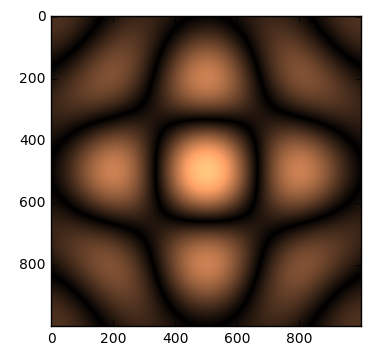

In [7]:
for mode in eigenmodes:
    if type(mode[0]) == type(1):
        #Not degenerate!
        print(mode)
        plt.imshow(np.abs(np.dot(eigenmode_function[mode[0]-1](x_domain_full)[:, None],
                   eigenmode_function[mode[1]-1](y_domain_full)[None])), cmap='copper')
        plt.show()
    else:
        #Degenerate!
        print(mode)
        plt.imshow(np.abs(np.dot(eigenmode_function[mode[0][0]-1](x_domain_full)[:, None],
                   eigenmode_function[mode[0][1]-1](y_domain_full)[None]) + \
                  np.dot(eigenmode_function[mode[1][0]-1](x_domain_full)[:, None],
                   eigenmode_function[mode[1][1]-1](y_domain_full)[None])), cmap='copper')
        plt.show()

Now, let's do it again but in the form of contour lines over our data:

In [8]:
import matplotlib.gridspec as gridspec

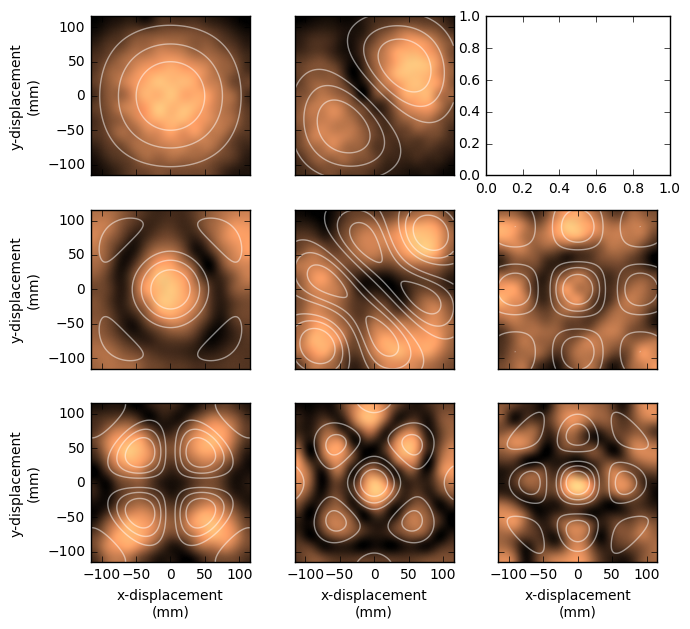

In [25]:
fig = plt.figure()
gs = gridspec.GridSpec(3, 3)
arrangement = np.arange(0, 9, 1).reshape(3, 3)
all_axes = []
for j, data_filename in enumerate(reversed(good_maps)):
    i = 8-j
    amplitude = np.load(data_filename)
    summed_z = np.average(amplitude, 2)
    #print(data_filename, eigenmodes[i]),
    #if j == 4:
    #    all_axes.append(fig.add_subplot(gs[np.argmin(np.abs(arrangement-i))],
    #                   sharex=all_axes[1], sharey=all_axes[3]))
    #elif j == 3:
    #    all_axes.append(fig.add_subplot(gs[np.argmin(np.abs(arrangement-i))],
    #                   sharex=all_axes[0]))
    #elif j == 5:
    #    all_axes.append(fig.add_subplot(gs[np.argmin(np.abs(arrangement-i))],
    #                   sharex=all_axes[2], sharey=all_axes[3]))
    
    all_axes.append(fig.add_subplot(gs[np.argmin(np.abs(arrangement-i))]))
    ax = all_axes[j]
    
    if i == 2:
        continue
    
    ax.imshow(summed_z, cmap='copper', interpolation='lanczos',
              extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint))
    
    mode = eigenmodes[i]
    if type(mode[0]) == type(1):
        #Not degenerate!
        #print(mode)
        theoretical_mode_full = np.abs(np.dot(eigenmode_function[mode[0]-1](x_domain_full)[:, None],
                   eigenmode_function[mode[1]-1](y_domain_full)[None]))
        ax.contour(theoretical_mode_full, colors='w',
                   extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint), alpha=0.5, 
                  levels=np.linspace(0, np.max(theoretical_mode_full), 5))
    else:
        #Degenerate!
        #print(mode)
        theoretical_mode_full = np.abs(np.dot(eigenmode_function[mode[0][0]-1](x_domain_full)[:, None],
                   eigenmode_function[mode[0][1]-1](y_domain_full)[None]) + \
                   np.dot(eigenmode_function[mode[1][0]-1](x_domain_full)[:, None], 
                          eigenmode_function[mode[1][1]-1](y_domain_full)[None]))
        ax.contour(theoretical_mode_full, colors='w',
                   extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint), alpha=0.5, 
                   levels=np.linspace(0, np.max(theoretical_mode_full), 5))
    #ax.set_xlabel("x-displacement (mm)")
    #ax.set_ylabel("y-displacement (mm)")
    if j in [3, 4, 6, 7]:
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklabels(), visible=False)
    elif j in [0, 1]:
        plt.setp(ax.get_yticklabels(), visible=False)
    elif j in [5, 8]:
        plt.setp(ax.get_xticklabels(), visible=False)

plt.setp([all_axes[i] for i in [0, 1, 2]], xlabel='x-displacement\n(mm)')
plt.setp([all_axes[i] for i in [2, 5, 8]], ylabel='y-displacement\n(mm)')

gs.tight_layout(fig, rect=[0, 0, 1.15, 1.6])
#plt.show()
#plt.savefig('all_amplitude_fits.pdf')
plt.savefig('all_amplitudes_fits2.pdf', bbox_inches='tight')

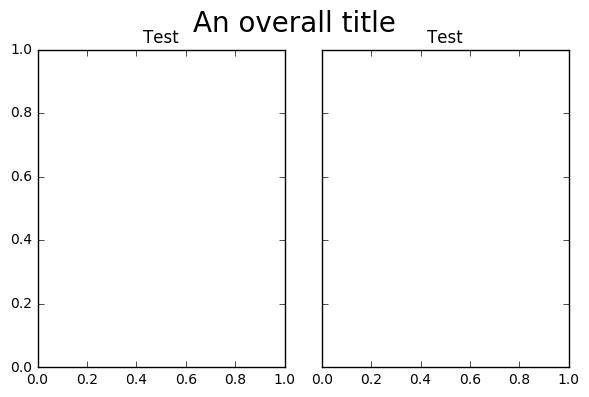

In [10]:
fig = plt.figure()
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp([ax1, ax2], title='Test')
fig.suptitle('An overall title', size=20)
gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
plt.show()

Now we actually fit each of these, and give the reduced chi square:

In [41]:
arrangement = np.arange(0, 9, 1).reshape(3, 3)
ADC_to_voltage = 1./95.6
vmax = 3.2*ADC_to_voltage
mm_per_gridpoint = 16.485
steps_to_edge = 7950. #\pm 50
steps_taken_max = 5000. #(some data has 5000)
phase_at_edge = 1.0
phase_at_max = phase_at_edge*steps_taken_max/steps_to_edge

for j, data_filename in enumerate(reversed(good_maps)):
    i = 8-j
    amplitude = np.load(data_filename)
    summed_z = np.average(amplitude, 2)
    if i == 2:
        continue
    
    grid_size = summed_z.shape[0]
    x_domain = np.linspace(-phase_at_edge, phase_at_edge, grid_size)
    y_domain = np.copy(x_domain)
    
    mode = eigenmodes[i]
    if type(mode[0]) == type(1):
        #Not degenerate!
        theoretical_mode = np.abs(np.dot(eigenmode_function[mode[0]-1](x_domain)[:, None],
                   eigenmode_function[mode[1]-1](y_domain)[None]))
    else:
        #Degenerate!
        theoretical_mode = np.abs(np.dot(eigenmode_function[mode[0][0]-1](x_domain)[:, None],
                   eigenmode_function[mode[0][1]-1](y_domain)[None]) + \
                   np.dot(eigenmode_function[mode[1][0]-1](x_domain)[:, None], 
                          eigenmode_function[mode[1][1]-1](y_domain)[None]))

    fit_param = minimize(lambda a: np.sum(np.square(a*theoretical_mode-summed_z)), x0=[1.0]).x[0]
    
    print("eigenmode", mode,
        np.sum(np.square(fit_param*theoretical_mode-summed_z)/0.3**2.)/(grid_size-1)**2.)

eigenmode [[3, 5], [5, 3]] 1.05811691554
eigenmode [[1, 5], [5, 1]] 6.19249373615
eigenmode [[2, 4], [4, 2]] 2.22398849095
eigenmode [3, 3] 4.05928632568
eigenmode [[2, 3], [3, 2]] 12.2850936105
eigenmode [[1, 3], [3, 1]] 1.92276021346
eigenmode [[1, 2], [2, 1]] 24.9902760893
eigenmode [1, 1] 13.8655158046
